# Preparação do Ambiente

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import HTML, display
from matplotlib import animation

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
def moving_average(rewards, window_size=10):
    n = len(rewards)
    grouped_means = [np.mean(rewards[i:i+window_size]) for i in range(0, n, window_size)]
    grouped_indices = [i for i in range(0, n, window_size)]
    return grouped_indices, grouped_means

In [4]:
def plot_rewards(train_rewards, test_rewards=None, title=None, max_reward=None, window_size=10):
    if test_rewards is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        axes = [axes]

    # TRAINING
    axes[0].plot(train_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
    train_x, train_avg = moving_average(train_rewards, window_size)
    axes[0].plot(train_x, train_avg, label=f'Média a cada {window_size}', color='orange')
    axes[0].set_title("Training")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward")

    if max_reward is not None:
        axes[0].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

    axes[0].legend()

    # TESTING
    if test_rewards is not None:
        axes[1].plot(test_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
        test_x, test_avg = moving_average(test_rewards, window_size)
        axes[1].plot(test_x, test_avg, label=f'Média a cada {window_size}', color='orange')
        axes[1].set_title("Testing")
        axes[1].set_xlabel("Episodes")
        axes[1].set_ylabel("Reward")

        if max_reward is not None:
            axes[1].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

        axes[1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

# Replay Buffer

In [5]:
class ReplayBuffer:
   def __init__(self, capacity, observation_shape):
      self._index = 0
      self._size = 0
      self._capacity = capacity
      self._memory = {
         "states": np.zeros((capacity, *observation_shape), dtype=np.float32),
         "actions": np.zeros((capacity,), dtype=np.int32),
         "rewards": np.zeros((capacity,), dtype=np.float32),
         "next_states": np.zeros((capacity, *observation_shape), dtype=np.float32),
         "dones": np.zeros((capacity,), dtype=np.int32)
      }
   
   def add(self, state, action, reward, next_state, done):
      self._memory["states"][self._index] = state
      self._memory["actions"][self._index] = action
      self._memory["rewards"][self._index] = reward
      self._memory["next_states"][self._index] = next_state
      self._memory["dones"][self._index] = done
      self._index = (self._index + 1) % self._capacity
      self._size = min(self._size + 1, self._capacity)
   
   def sample(self, batch_size):
      indexes = np.random.choice(self._size, batch_size, replace=False)
      return (
         self._memory["states"][indexes],
         self._memory["actions"][indexes],
         self._memory["rewards"][indexes],
         self._memory["next_states"][indexes],
         self._memory["dones"][indexes]
      )
      
   def __len__(self):
      return self._size

# Definição da Rede

In [6]:
class NoisyLinear(nn.Module):
   def __init__(self, observation_shape, action_shape, std_init: float = 0.5):
      super(NoisyLinear, self).__init__()
      self.in_features = observation_shape
      self.out_features = action_shape
      self.std_init = std_init
      
      self.weight_mu = nn.Parameter(torch.Tensor(action_shape, observation_shape))
      self.weight_sigma = nn.Parameter(torch.Tensor(action_shape, observation_shape))
      self.register_buffer(
         "weight_epsilon", torch.Tensor(action_shape, observation_shape)
      )
      
      self.bias_mu = nn.Parameter(torch.Tensor(action_shape))
      self.bias_sigma = nn.Parameter(torch.Tensor(action_shape))
      self.register_buffer(
         "bias_epsilon", torch.Tensor(action_shape)
      )
      
      self.reset_parameters()
      self.reset_noise()
      
   def reset_parameters(self):
      mu_range = 1 / np.sqrt(self.in_features)
      
      self.weight_mu.data.uniform_(-mu_range, mu_range)
      self.weight_sigma.data.fill_(
         self.std_init / np.sqrt(self.in_features)
      )
      
      self.bias_mu.data.uniform_(-mu_range, mu_range)
      self.bias_sigma.data.fill_(
         self.std_init / np.sqrt(self.out_features)
      )
   
   def reset_noise(self):
      epsilon_in = self.scale_noise(self.in_features)
      epsilon_out = self.scale_noise(self.out_features)
      
      self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
      self.bias_epsilon.copy_(epsilon_out)
   
   @staticmethod
   def scale_noise(size: int) -> torch.Tensor:
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())
   
   def forward(self, x):
      return F.linear(
         x,
         self.weight_mu + self.weight_sigma * self.weight_epsilon,
         self.bias_mu + self.bias_sigma * self.bias_epsilon
      )

In [7]:
class NoisyDQN(nn.Module):
   def __init__(self, observation_shape, action_shape):
      super(NoisyDQN, self).__init__()
      self.feature = nn.Linear(observation_shape[0], 128)
      self.noisy1 = NoisyLinear(128, 128)
      self.noisy2 = NoisyLinear(128, action_shape)
   
   def forward(self, x):
      x = F.relu(self.feature(x))
      x = F.relu(self.noisy1(x))
      x = self.noisy2(x)
      return x
   
   def reset_noise(self):
      self.noisy1.reset_noise()
      self.noisy2.reset_noise()

# Definição do Agente

In [8]:
class NoisyDQNAgent:
   def __init__(self, env,
                alpha=1e-3,
                gamma=0.999,
                batch_size=64,
                target_update=100,
                replay_buffer_size=100000):
      self.alpha = alpha
      self.gamma = gamma
      self.batch_size = batch_size
      self.target_update = target_update
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.env = env
      
      self.dqn = NoisyDQN(env.observation_space.shape, env.action_space.n).to(self.device)
      self.dqn_target = NoisyDQN(env.observation_space.shape, env.action_space.n).to(self.device)

      self.dqn_target.load_state_dict(self.dqn.state_dict())
      self.dqn_target.eval()
      
      self.replay = ReplayBuffer(replay_buffer_size, env.observation_space.shape)
      
      self.optimizer = optim.Adam(self.dqn.parameters(), lr=alpha)
      self.loss = nn.SmoothL1Loss()
      
      self.transaction = list()
      self.is_test = False
      
   def act(self, state):
      self.dqn.eval()
      
      with torch.no_grad():
         state = torch.tensor(state, dtype=torch.float32).to(self.device)
         action = self.dqn(state).argmax(dim=-1).item()
      
      if not self.is_test:
         self.transaction = [state, action]
      
      return action

   def step(self, action):
      next_state, reward, terminated, truncated, _ = self.env.step(action)
      done = terminated or truncated
      
      if not self.is_test:
         self.transaction += [reward, next_state, done]
         self.replay.add(*self.transaction)
      
      return next_state, reward, done
      
   def update(self):
      self.dqn.train()
      
      states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)
      
      states = torch.as_tensor(states).to(self.device)
      actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
      rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
      next_states = torch.as_tensor(next_states).to(self.device)
      dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)
      mask = 1 - dones
      q_eval = self.dqn(states).gather(-1, actions.long())
      
      with torch.no_grad():
         q_next = self.dqn_target(next_states).max(dim=-1)[0].unsqueeze(-1)
         q_target = (rewards + self.gamma * q_next * mask).to(self.device)
      
      loss = self.loss(q_eval, q_target)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      
      self.dqn.reset_noise()
      self.dqn_target.reset_noise()
         
   def train(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Training", disable=not verbose)
      rewards = []
      updated_count = 0
      self.is_test = False
            
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, done = self.step(action)
            state = next_state
            episode_reward += reward
            
            if len(self.replay) > self.batch_size:
               updated_count += 1
               self.update()

               if updated_count % self.target_update == 0:
                  self.dqn_target.load_state_dict(self.dqn.state_dict())
                  
         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward})
         
      return rewards
   
   def evaluate(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Evaluating", disable=not verbose)
      rewards = []
      self.is_test = True
      
      self.dqn.eval()
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, done = self.step(action)
            state = next_state
            episode_reward += reward
            
         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward })
               
      return rewards

   def save(self, path):
      torch.save(self.dqn.state_dict(), path)
   
   def load(self, path):
      self.dqn.load_state_dict(torch.load(path))

   def render(self, env, max_steps: int = 500, interval: int = 30, figsize: tuple = (6, 6)):
      """
      Executa o agente no ambiente por até max_steps, captura frames e exibe
      uma animação inline no notebook.
      """
      frames = []
      state, _ = env.reset()
      done = False

      for _ in range(max_steps):
         # captura frame como array RGB
         frame = env.render()
         frames.append(frame)

         # ação greedy (sem exploração)
         action = self.act(state)
         state, reward, terminated, truncated, _ = env.step(action)
         done = terminated or truncated
         if done:
               break

      # fecha o ambiente
      env.close()

      # monta figure/axis
      fig = plt.figure(figsize=figsize)
      plt.axis("off")
      im = plt.imshow(frames[0])

      # função de atualização para cada frame
      def animate(i):
         im.set_array(frames[i])
         return [im]

      # cria a animação
      anim = animation.FuncAnimation(
         fig, animate, frames=len(frames), interval=interval
      )
      display(HTML(anim.to_jshtml()))

# Ambientes

In [9]:
envs = [
    ("CartPole-v1",       "CartPole",       "cartpole_noisy_dqn.pt",      500),
    ("Acrobot-v1",        "Acrobot",        "acrobot_noisy_dqn.pt",       0),
    ("MountainCar-v0",    "MountainCar",    "mountaincar_noisy_dqn.pt",   -50),
    ("LunarLander-v3",    "LunarLander",    "lunarlander_noisy_dqn.pt",   200),
]

Training CartPole...


Evaluating: 100%|██████████| 100/100 [00:03<00:00, 33.01it/s, Reward=196]


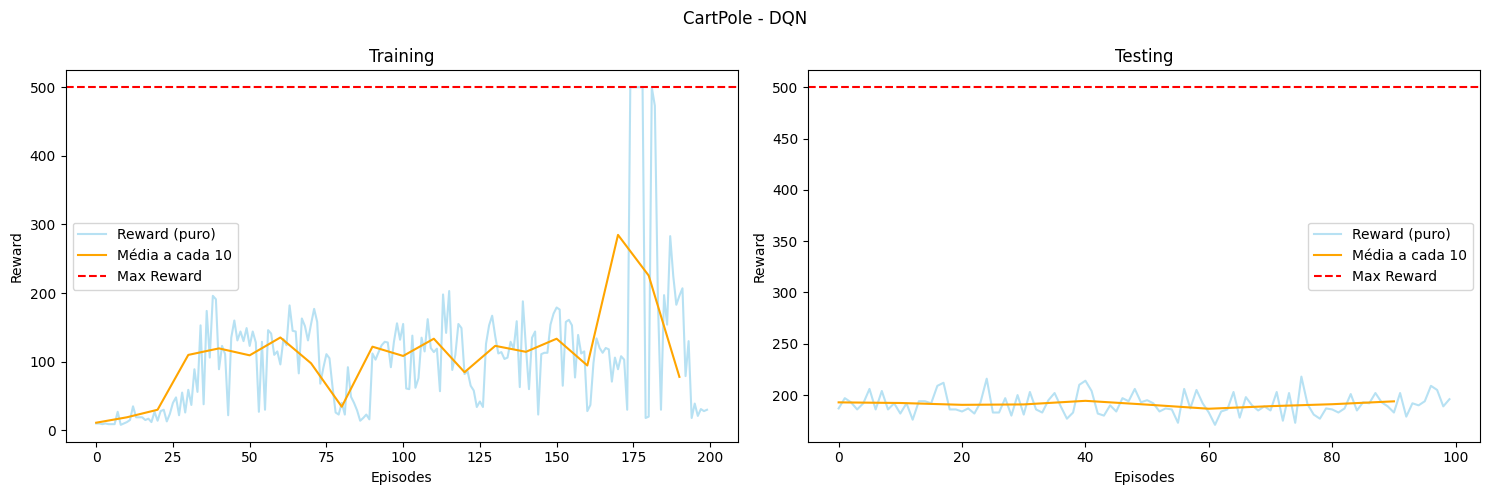

Done!

Training Acrobot...


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 45.45it/s, Reward=-83]


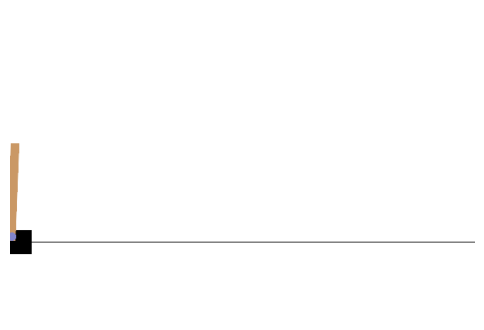

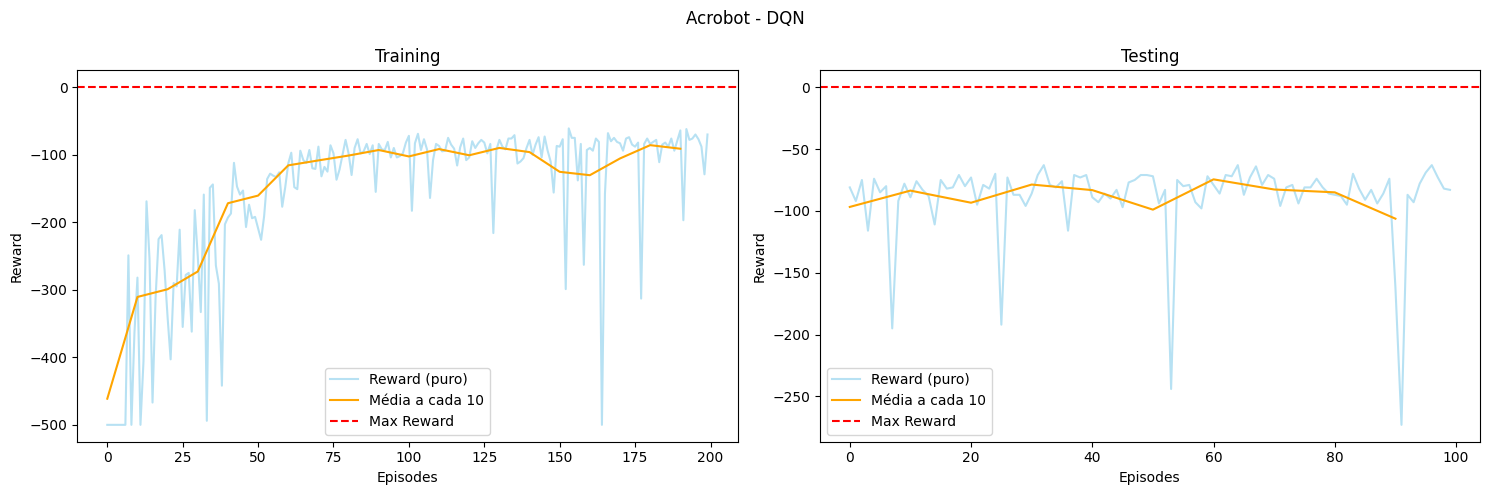

Done!

Training MountainCar...


Evaluating: 100%|██████████| 100/100 [00:03<00:00, 30.05it/s, Reward=-200]


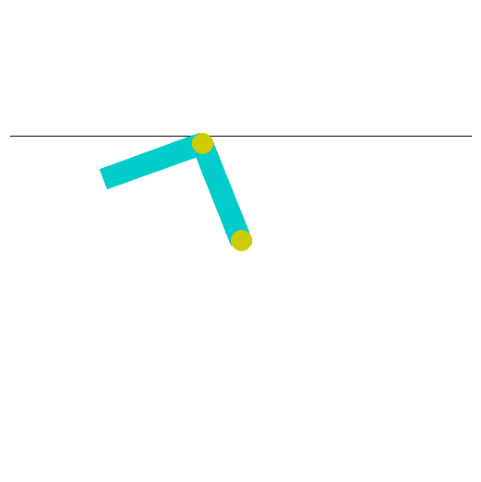

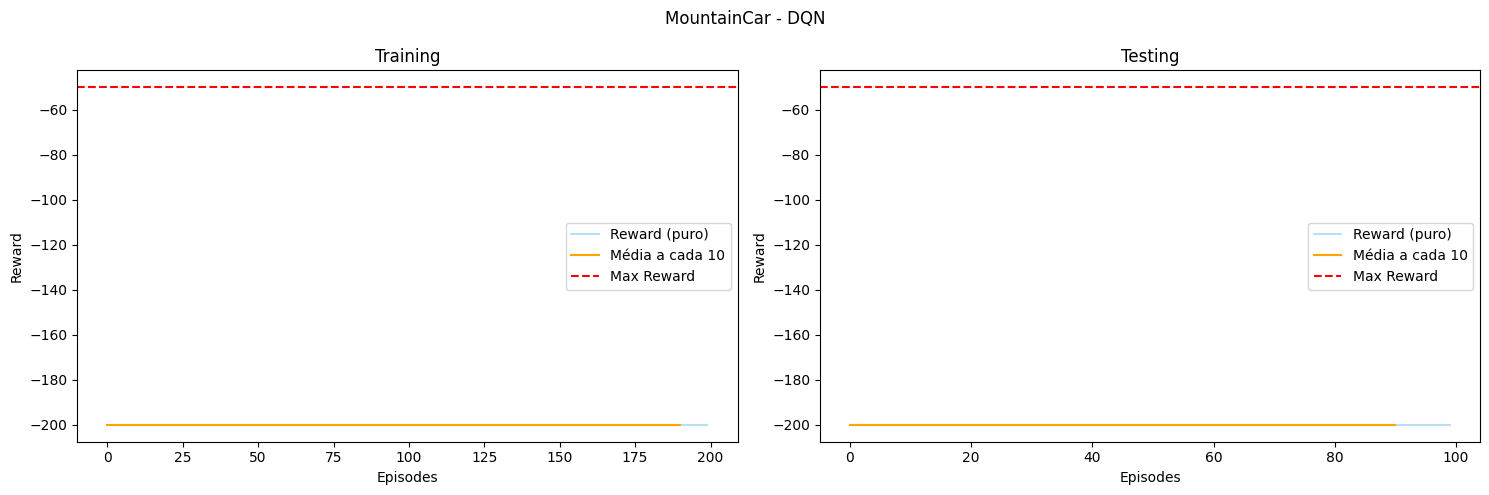

Done!

Training LunarLander...


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 71.49it/s, Reward=-360]


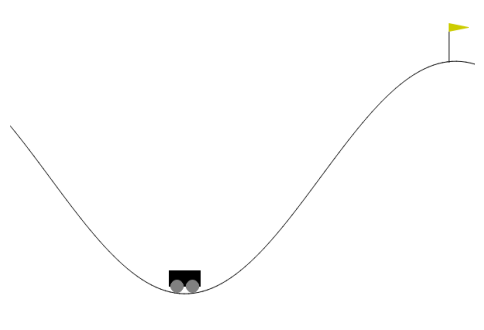

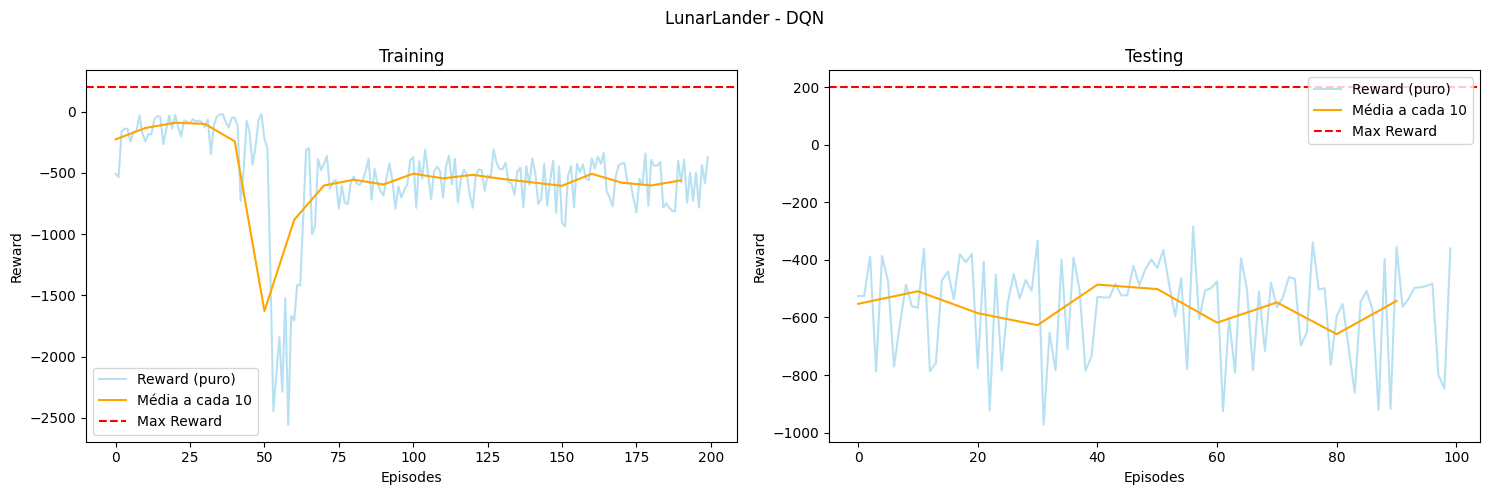

Done!



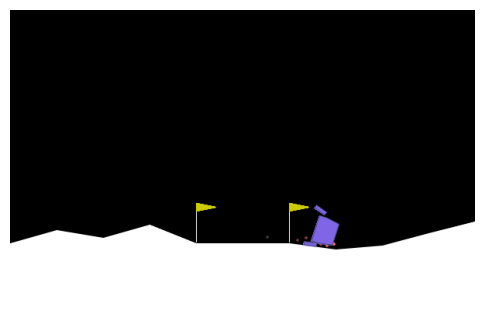

In [10]:
for env_name, env_title, path, max_reward in envs:
   print(f"Training {env_title}...")
   
   env = gym.make(env_name)
   agent = NoisyDQNAgent(env)
   
   train_rewards = agent.train(200, verbose=True)
   test_rewards = agent.evaluate(100, verbose=True)
   
   agent.save(f'checkpoint/{path}')
   
   plot_rewards(train_rewards, test_rewards, f"{env_title} - DQN", max_reward=max_reward)
   
   env = gym.make(env_name, render_mode="rgb_array")
   agent.render(env, max_steps=500, interval=30, figsize=(6, 6))
      
   print("Done!\n")